<a href="https://colab.research.google.com/github/abdulquawiyy-owolabi/Deep-Learning/blob/main/Optimisation_Day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import copy
import random

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [2]:
# @title Helper functions
def print_params(model):
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name, param.data)

In [3]:
# @title Set Random Seed

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

worker_seed = torch.initial_seed() % 2**32
np.random.seed(worker_seed)
random.seed(worker_seed)

In [4]:
# @title Set GPU

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is", torch.cuda.get_device_name(0))
  return device

In [5]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

GPU is Tesla T4


In [6]:
# @title Download MNIST Dataset

import tarfile, requests, os

fname = "MNIST.tar.gz"
name = "MNIST"
url = "https://osf.io/y2fj6/download"

if not os.path.exists(fname):
  print("\nDownloading MNIST dataset. ")
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print("\nDownloading MNIST completed")

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall()
    tar.close()
    os.remove(fname)
else:
  print("Dataset already exists")



Dataset already exists


In [7]:
# @title Load the MNIST Data
def load_mnist_data(change_tensors=False, download=False):

  # Load Train and test set
  train_set = datasets.MNIST(root=".",
                             download =download, train=True,
                             transform=torchvision.transforms.ToTensor()
                             )
  test_set = datasets.MNIST(root=".",
                            train=False,
                            download=download,
                            transform=torchvision.transforms.ToTensor()
                            )

  # Normalise the dataset wrt to its mean and std
  mean = train_set.data.float().mean()
  std = train_set.data.float().std()

  if change_tensors:
    train_set.data = (train_set.data.float() - mean) / std
    test_set.data = (test_set.data.float() - mean) / std
  else:
    tform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[mean/255.],
       std=[std/255.])
    ])
    train_set = datasets.MNIST(root='.',
                              train=True, download=download,
                              transform=tform)
    test_set = datasets.MNIST(root='.',
                             train=False, download=download,
                             transform=tform)
  return train_set, test_set

In [8]:
train_set, test_set = load_mnist_data(change_tensors=True)

In [9]:
# @title Sample 1000 Data Indice

subset_index = np.random.choice(len(train_set), 1000, replace=False)

X,y = train_set.data[subset_index, :], train_set.targets[subset_index]

In [10]:
X.data.shape

torch.Size([1000, 28, 28])

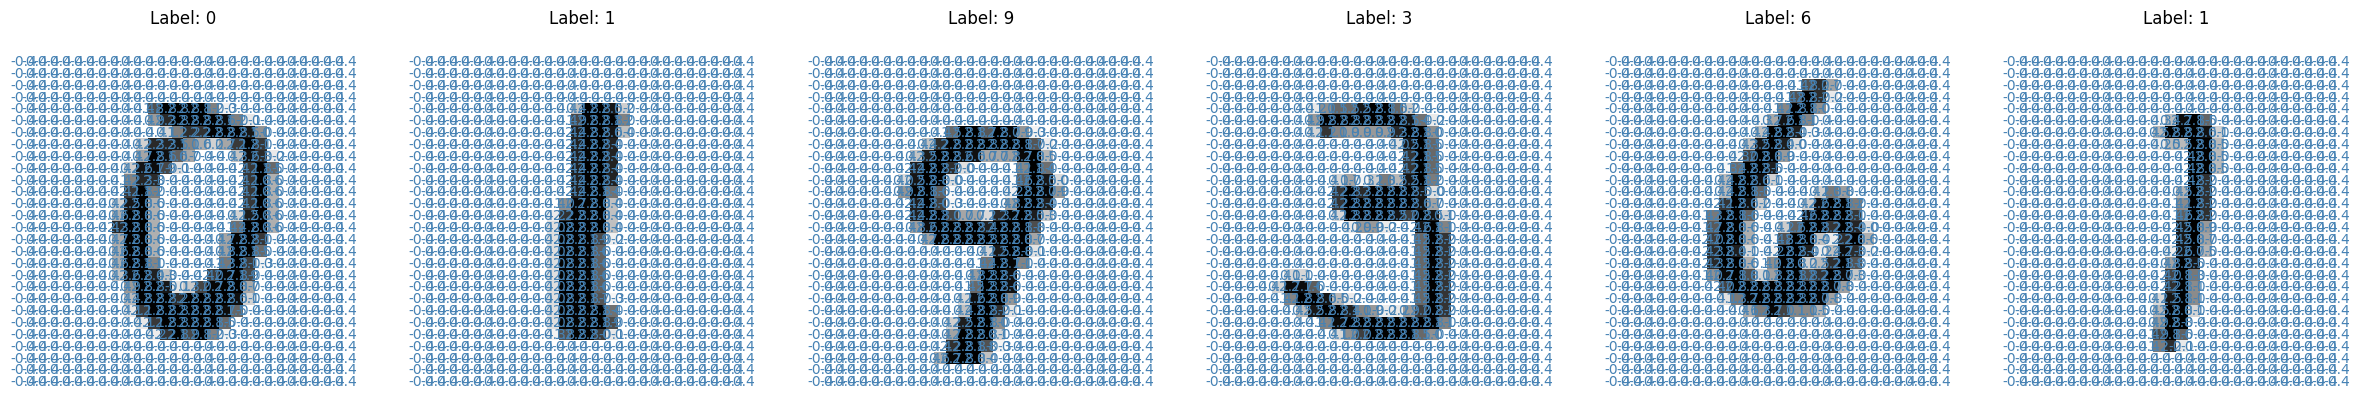

In [11]:
# @title Visualize some Image

num_figures = 6

fig, axs = plt.subplots(1, num_figures, figsize=(5*num_figures, 5))

for sample_id, ax in enumerate(axs):
  ax.matshow(X[sample_id, :], cmap='gray_r')
  for (i,j), z in np.ndenumerate(X[sample_id, :]):
    text='{:.1f}'.format(z)
    ax.text(j, i, text, va='center', ha='center', fontsize=10,
            c='steelblue')
  ax.set_title('Label: ' + str(y[sample_id].item()))
  ax.axis('off')
plt.show()

In [12]:
# @title Model


class MLP(nn.Module):
  def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):

    super(MLP, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
    if len(hidden_dims) == 0:
      layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
    else:
      # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
      layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

      # Loop until before the last layer
      for i, hidden_dim in enumerate(hidden_dims[:-1]):
        layers += [nn.Linear(hidden_dim, hidden_dims[i + 1], bias=use_bias),
                   nn.ReLU()]

      # Add final layer to the number of classes
      layers += [nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]

    self.main = nn.Sequential(*layers)

  def forward(self, x):
    # Flatten each images into a 'vector'
    transformed_x = x.view(-1, self.in_dim)
    hidden_output = self.main(transformed_x)
    output = F.log_softmax(hidden_output, dim=1)
    return output

In [13]:
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print(model)

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [14]:
# @title Loss

loss_fn = F.nll_loss
loss_fn

<function torch.nn.functional.nll_loss(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor] = None, size_average: Optional[bool] = None, ignore_index: int = -100, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [15]:
cell_verbose = False
partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
  print('Init loss', loss_fn(partial_trained_model(X), y).item()) # This matches around np.log(10 = # of classes)

# Invoke an optimizer using Adaptive gradient and Momentum (more about this in Section 7)
optimizer = optim.Adam(partial_trained_model.parameters(), lr=7e-4)
for _ in range(200):
  loss = loss_fn(partial_trained_model(X), y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

if cell_verbose:
  print('End loss', loss_fn(partial_trained_model(X), y).item()) # This should be less than 1e-2

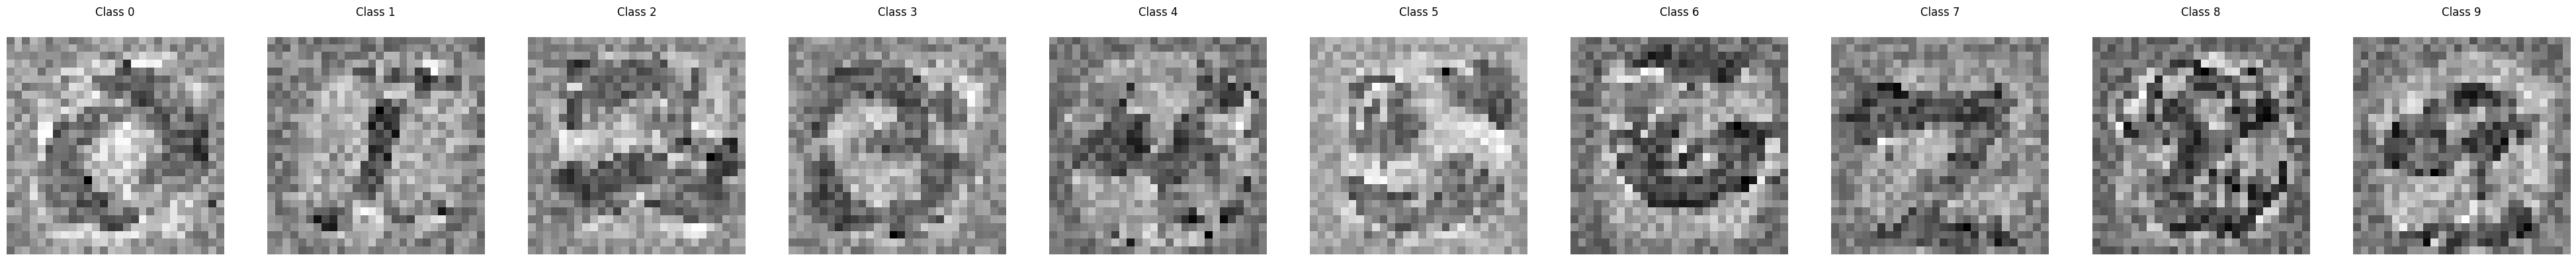

In [16]:
W = partial_trained_model.main[0].weight.detach().numpy()

fig, axs = plt.subplots(1, 10, figsize=(5*10, 5))
for class_id in range(10):
  axs[class_id].matshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
  axs[class_id].axis('off')
  axs[class_id].set_title('Class ' + str(class_id))
plt.show()


In [17]:
# @title Implementing Gradient Descent

def zero_grad(params):
  for par in params:
    if not(par.grad is None):
      par.grad.detach_()
      par.grad.zero_()

def random_update(model, noise_scale=.1,normalized = False):
   for par in model.parameters():
    noise = torch.randn_like(par)
    if normalized:
      noise /= torch.norm(noise)
    par.data += noise_scale * noise

In [18]:
def gradient_update(loss, params, lr=1e-3):
  zero_grad(params)
  loss.backward()

  with torch.no_grad():
    for par in params:
      par.data -= lr * par.grad

In [19]:
set_seed(seed=SEED)
model1 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print("\n The model Parameters before update are:  \n")
print_params(model1)
loss = loss_fn(model1(X), y)
gradient_update(loss, list(model1.parameters()), lr=1e-2)
print("\n The model Parameters after update are:  \n")
print_params(model1)


 The model Parameters before update are:  

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model Parameters after update are:  

main.0.weight tensor([[-0.0264,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0221],
        [-0.0042, -0.0297, -0.0088,  ..., -0.0072,  0.0253, -0.0235],
        [ 0.0241, -0.0230,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0158,  0.0111,  ...,  0.0144, -0.0301, -0.0143],
        [ 0.0180,  0.0302,  0.0254,  

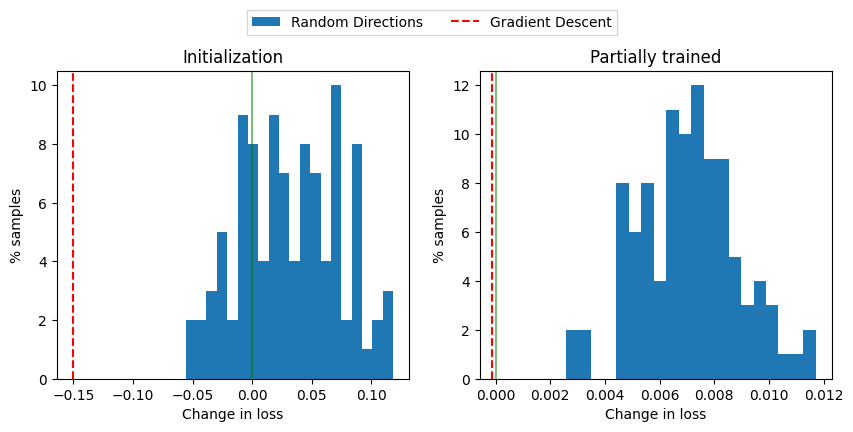

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for id, (model_name, my_model) in enumerate([('Initialization', model),
                                              ('Partially trained', partial_trained_model)]):
  # Compute the loss we will be comparing to
  base_loss = loss_fn(my_model(X), y)

  # Compute the improvement via gradient descent
  dummy_model = copy.deepcopy(my_model)
  loss1 = loss_fn(dummy_model(X), y)
  gradient_update(loss1, list(dummy_model.parameters()), lr=1e-2)
  gd_delta = loss_fn(dummy_model(X), y) - base_loss

  deltas = []
  for trial_id in range(100):
    # Compute the improvement obtained with a random direction
    dummy_model = copy.deepcopy(my_model)
    random_update(dummy_model, noise_scale=1e-2)
    deltas.append((loss_fn(dummy_model(X), y) - base_loss).item())

  # Plot histogram for random direction and vertical line for gradient descent
  axs[id].hist(deltas, label='Random Directions', bins=20)
  axs[id].set_title(model_name)
  axs[id].set_xlabel('Change in loss')
  axs[id].set_ylabel('% samples')
  axs[id].axvline(0, c='green', alpha=0.5)
  axs[id].axvline(gd_delta.item(), linestyle='--', c='red', alpha=1,
                  label='Gradient Descent')


handles, labels = axs[id].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           fancybox=False, shadow=False, ncol=2)

plt.show()

In [21]:
def loss_2d(model, u, v, mask_idx=(0, 378), bias_id=7):

  # We zero out the element of the weight tensor that will be
  # replaced by u
  mask = torch.ones_like(model.main[0].weight)
  mask[mask_idx[0], mask_idx[1]] = 0.
  masked_weights = model.main[0].weight * mask

  # u is replacing an element of the weight matrix
  masked_weights[mask_idx[0], mask_idx[1]] = u

  res = X.reshape(-1, 784) @ masked_weights.T + model.main[0].bias

  # v is replacing a bias for class 7
  res[:, 7] += v - model.main[0].bias[7]
  res =  F.log_softmax(res, dim=1)

  return loss_fn(res, y)


def plot_surface(U, V, Z, fig):
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.view_init(45, -130)

  surf = ax.plot_surface(U, V, Z, cmap=plt.cm.coolwarm,
                      linewidth=0, antialiased=True, alpha=0.5)

  # Select certain level contours to plot
  # levels = Z.min() * np.array([1.005, 1.1, 1.3, 1.5, 2.])
  # plt.contour(U, V, Z)# levels=levels, alpha=0.5)

  ax.set_xlabel('Weight')
  ax.set_ylabel('Bias')
  ax.set_zlabel('Loss', rotation=90)

  return ax


def plot_param_distance(best_u, best_v, trajs, fig, styles, labels,
                        use_log=False, y_min_v=-12.0, y_max_v=1.5):
  ax = fig.add_subplot(1, 1, 1)

  for traj, style, label in zip(trajs, styles, labels):
    d0 = np.array([np.abs(_[0] - best_u) for _ in traj])
    d1 = np.array([np.abs(_[1] - best_v) for _ in traj])
    if use_log:
      d0 = np.log(1e-16 + d0)
      d1 = np.log(1e-16 + d1)
    ax.plot(range(len(traj)), d0, style, label='weight - ' + label)
    ax.plot(range(len(traj)), d1, style, label='bias - ' + label)
  ax.set_xlabel('Iteration')
  if use_log:
    ax.set_ylabel('Log distance to optimum (per dimension)')
    ax.set_ylim(y_min_v, y_max_v)
  else:
    ax.set_ylabel('Abs distance to optimum (per dimension)')
  ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5),
            fancybox=False, shadow=False, ncol=1)

  return ax


def run_optimizer(inits, eval_fn, update_fn, max_steps=500,
                  optim_kwargs={'lr':1e-2}, log_traj=True):

  # Initialize parameters and optimizer
  params = [nn.Parameter(torch.tensor(_)) for _ in inits]
  # Methods like momentum and rmsprop keep and auxiliary vector of parameters
  aux_tensors = [torch.zeros_like(_) for _ in params]
  if log_traj:
    traj = np.zeros((max_steps, len(params)+1))
  for _ in range(max_steps):
    # Evaluate loss
    loss = eval_fn(*params)
    # Store 'trajectory' information
    if log_traj:
      traj[_, :] = [_.item() for _ in params] + [loss.item()]
    # Perform update
    if update_fn == gradient_update:
      gradient_update(loss, params, **optim_kwargs)
    else:
      update_fn(loss, params, aux_tensors, **optim_kwargs)
  if log_traj:
    return traj


L = 4.
xs = np.linspace(-L, L, 30)
ys = np.linspace(-L, L, 30)
U, V = np.meshgrid(xs, ys)

In [22]:
def momentum_uptdate(loss, params, grad_vel, lr=1e-3, beta=0.9):
  zero_grad(params)
  loss.backward()
  with torch.no_grad():
    for (par, vel) in zip(params, grad_vel):
      # update velocity
      vel.data = -lr * par.grad.data + beta * vel.data
      # update parameter
      par.data += vel.data

set_seed(seed=SEED)
model2 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print("\n The model Parameters before update are:  \n")
print_params(model2)
loss = loss_fn(model2(X), y)
momentum_uptdate(loss, list(model2.parameters()), list(model2.parameters()))
print("\n The model Parameters after update are:  \n")
print_params(model2)



 The model Parameters before update are:  

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model Parameters after update are:  

main.0.weight tensor([[-0.0475,  0.0017,  0.0312,  ...,  0.0535,  0.0500, -0.0398],
        [-0.0073, -0.0532, -0.0156,  ..., -0.0127,  0.0458, -0.0420],
        [ 0.0433, -0.0415,  0.0616,  ...,  0.0223,  0.0486, -0.0325],
        ...,
        [-0.0009,  0.0283,  0.0199,  ...,  0.0259, -0.0541, -0.0258],
        [ 0.0325,  0.0545,  0.0459,  

In [23]:
# @title Implement Gradient Descent

def sample_minibatch(input_data, target_data, num_points=100):
  batch_indices = np.random.choice(len(input_data), num_points, replace=False)
  batch_input = input_data[batch_indices, :]
  batch_target = target_data[batch_indices]
  return batch_input, batch_target

In [24]:
x_batch, y_batch = sample_minibatch(X, y, num_points=100)
print(f"The input shape is {x_batch.shape} and the target shape is {y_batch.shape}")

The input shape is torch.Size([100, 28, 28]) and the target shape is torch.Size([100])


In [25]:
# @title Implement RMSProp

def rmsprop_update(loss, params, grad_sq, lr=1e-3, alpha=0.8, eps=1e-8):
  zero_grad(params)
  # compuute gradient on a given objective
  loss.backward()

  with torch.no_grad():
    for (par, gsq) in zip(params, grad_sq):
      # Update estimate of gradient variance
      gsq.data = alpha * gsq.data + (1 - alpha) * par.grad.data ** 2
      # Update parameter
      par.data -= lr * par.grad.data / (torch.sqrt(gsq.data) + eps)

set_seed(seed=SEED)
model3 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print("\n The model Parameters before update are:  \n")
print_params(model3)
loss = loss_fn(model3(X), y)
grad_sq = [1e-6*i for i in list(model3.parameters())]

rmsprop_update(loss, list(model3.parameters()), grad_sq=grad_sq, lr=1e-3)
print("\n The model Parameters after update are:  \n")
print_params(model3)


 The model Parameters before update are:  

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model Parameters after update are:  

main.0.weight tensor([[-0.0242,  0.0032,  0.0196,  ...,  0.0320,  0.0300, -0.0199],
        [-0.0063, -0.0318, -0.0109,  ..., -0.0093,  0.0232, -0.0255],
        [ 0.0263, -0.0208,  0.0364,  ...,  0.0146,  0.0292, -0.0158],
        ...,
        [ 0.0017,  0.0179,  0.0132,  ...,  0.0166, -0.0276, -0.0120],
        [ 0.0159,  0.0281,  0.0233,  

In [26]:
# @title Download parameters of the benchmark model
import requests

fname = 'benchmark_model.pt'
url = "https://osf.io/sj4e8/download"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content)

# Load the benchmark model's parameters
DEVICE = set_device()
if DEVICE == "cuda":
  benchmark_state_dict = torch.load(fname)
else:
  benchmark_state_dict = torch.load(fname, map_location=torch.device('cpu'))

GPU is Tesla T4


In [27]:
# Create MLP object and update weights with those of saved model
benchmark_model = MLP(in_dim=784, out_dim=10,
                      hidden_dims=[200, 100, 50]).to(DEVICE)
benchmark_model.load_state_dict(benchmark_state_dict)


# Define helper function to evaluate models
def eval_model(model, data_loader, num_batches=np.inf, device='cpu'):

  loss_log, acc_log = [], []
  model.to(device=device)

  # We are just evaluating the model, no need to compute gradients
  with torch.no_grad():
    for batch_id, batch in enumerate(data_loader):
      # If we only evaluate a number of batches, stop after we reach that number
      if batch_id > num_batches:
        break
      # Extract minibatch data
      data, labels = batch[0].to(device), batch[1].to(device)
      # Evaluate model and loss on minibatch
      preds = model(data)
      loss_log.append(loss_fn(preds, labels).item())
      acc_log.append(torch.mean(1. * (preds.argmax(dim=1) == labels)).item())

  return np.mean(loss_log), np.mean(acc_log)

In [32]:
# @title Train the model

MAX_EPOCHS = 5
LR = 1e-4
BATCH_SIZE = 40

my_model = MLP(in_dim=784, out_dim=10, hidden_dims=[200, 100, 50]).to(DEVICE)
optimizer = torch.optim.RMSprop(my_model.parameters(), lr=LR,
                                alpha=0.99)

In [33]:
# @title Train the model

MAX_EPOCHS = 2
LR = 1e-4
BATCH_SIZE = 65

my_model = MLP(in_dim=784, out_dim=10, hidden_dims=[200, 100, 50]).to(DEVICE)
optimizer = torch.optim.RMSprop(my_model.parameters(), lr=LR,
                                alpha=0.99)

set_seed(seed=SEED)
LOG_FREQ = 200
VAL_FREQ = 200

train_set_orig, test_set_orig = load_mnist_data(change_tensors=False)

# Separate 10,000 trainig samples to create a validation set
train_set_orig, val_set_orig = torch.utils.data.random_split(train_set_orig,
                                                             [50000, 10000])

# Create corresponding DataLoader for training and test
g_seed = torch.Generator().manual_seed(SEED)
train_loader = torch.utils.data.DataLoader(train_set_orig,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=2,
                                           generator=g_seed,
                                           worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(val_set_orig,
                                         batch_size=256,
                                         shuffle=False,
                                         num_workers=2,
                                         generator=g_seed,
                                         worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(test_set_orig,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

# Run training
metrics = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': [],
           'val_idx':[]
           }
step_idx = 0
for epoch in tqdm(range(MAX_EPOCHS)):
  running_loss, running_acc = 0., 0.
  for batch_id, batch in enumerate(train_loader):
    step_idx += 1
    # Extract minibatch data and label
    data, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
    optimizer.zero_grad()
    # Evaluate model
    preds = my_model(data)
    loss = loss_fn(preds, labels)
    acc = torch.mean(1. * (preds.argmax(dim=1) == labels))
    # Compute gradient
    loss.backward()
    # Update parameters
    optimizer.step()
    # Log metrics plotting
    metrics['train_loss'].append(loss.item())
    metrics['train_acc'].append(acc.item())

    if batch_id % VAL_FREQ == (VAL_FREQ - 1):
      val_loss, val_acc = eval_model(my_model, val_loader,
                                     num_batches=100,
                                     device=DEVICE)
      metrics['val_loss'].append(val_loss)
      metrics['val_acc'].append(val_acc)
      metrics['val_idx'].append(step_idx)

      print(f"[VALID] Epoch {epoch +1} - Batch {batch_id + 1} - "
            f"Loss: {val_loss:.4f} - Acc: {100 * val_acc:.4f}%")

      # print statistics
      running_loss += loss.cpu().item()
      running_acc += acc.cpu().item()
      if batch_id % LOG_FREQ == (LOG_FREQ - 1):
        print(f"[TRAIN] Epoch {epoch +1} - Batch {batch_id + 1} - "
              f"Loss: {running_loss / LOG_FREQ:.4f} - Acc: {100 * running_acc / LOG_FREQ:.4f}%")
        running_loss, running_acc = 0., 0.

  0%|          | 0/2 [00:00<?, ?it/s]

[VALID] Epoch 1 - Batch 200 - Loss: 0.5106 - Acc: 86.5527%
[TRAIN] Epoch 1 - Batch 200 - Loss: 0.0023 - Acc: 0.4231%
[VALID] Epoch 1 - Batch 400 - Loss: 0.3827 - Acc: 89.3652%
[TRAIN] Epoch 1 - Batch 400 - Loss: 0.0017 - Acc: 0.4615%
[VALID] Epoch 1 - Batch 600 - Loss: 0.3312 - Acc: 90.9473%
[TRAIN] Epoch 1 - Batch 600 - Loss: 0.0025 - Acc: 0.4538%
[VALID] Epoch 2 - Batch 200 - Loss: 0.2811 - Acc: 91.7480%
[TRAIN] Epoch 2 - Batch 200 - Loss: 0.0008 - Acc: 0.4846%
[VALID] Epoch 2 - Batch 400 - Loss: 0.2636 - Acc: 92.4023%
[TRAIN] Epoch 2 - Batch 400 - Loss: 0.0010 - Acc: 0.4615%
[VALID] Epoch 2 - Batch 600 - Loss: 0.2529 - Acc: 92.6758%
[TRAIN] Epoch 2 - Batch 600 - Loss: 0.0013 - Acc: 0.4462%


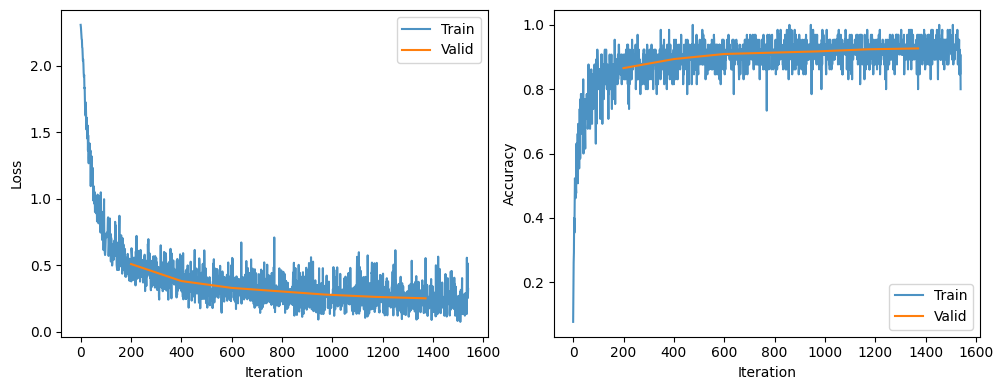

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(len(metrics['train_loss'])), metrics['train_loss'],
           alpha=0.8, label='Train')
ax[0].plot(metrics['val_idx'], metrics['val_loss'], label='Valid')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(len(metrics['train_acc'])), metrics['train_acc'],
           alpha=0.8, label='Train')
ax[1].plot(metrics['val_idx'], metrics['val_acc'], label='Valid')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [35]:
print('Your model...')
train_loss, train_accuracy = eval_model(my_model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(my_model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')

print('\nBenchmark model')
train_loss, train_accuracy = eval_model(benchmark_model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(benchmark_model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')

Your model...
Train Loss 0.283 / Test Loss 0.279
Train Accuracy 91.510% / Test Accuracy 91.377%

Benchmark model
Train Loss 0.011 / Test Loss 0.025
Train Accuracy 99.784% / Test Accuracy 99.316%
